In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("./datasets/DCFC_load.csv")
load_df = df.drop((['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7']),axis=1)
load_df

,Time,PowerkW2
0,01/01/22 0:00,23.146460
1,01/01/22 0:15,17.971620
2,01/01/22 0:30,6.735884
3,01/01/22 0:45,0.000000
4,01/01/22 1:00,0.000000
...,...,...
35035,31/12/22 22:42,15.200730
35036,31/12/22 22:57,0.000000
35037,31/12/22 23:12,0.000000
35038,31/12/22 23:27,0.000000


In [3]:
time = pd.to_datetime(load_df['Time'], format='%d/%m/%y %H:%M')
# load_df.set_index('Time', inplace=True)

In [4]:
time[:2976]

0      2022-01-01 00:00:00
1      2022-01-01 00:15:00
2      2022-01-01 00:30:00
3      2022-01-01 00:45:00
4      2022-01-01 01:00:00
               ...        
2971   2022-01-31 22:44:00
2972   2022-01-31 22:59:00
2973   2022-01-31 23:14:00
2974   2022-01-31 23:29:00
2975   2022-01-31 23:44:00
Name: Time, Length: 2976, dtype: datetime64[ns]

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      label (list of strings)- tag for the line
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Plot the time series data
    plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    if label:
      plt.legend(fontsize=14, labels=label)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [6]:
series = load_df['PowerkW2']

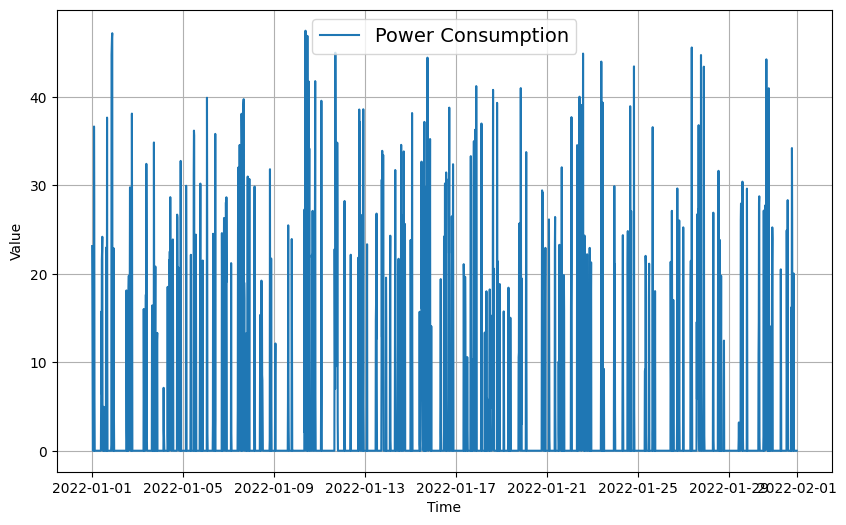

In [7]:
# Limit the plot to a specific time range, e.g., the first 2976 data points which basically represents the month of
# January
time_1 = time[:2976]
series_1 = series[:2976]

# Call the plot_series function with the limited data
plot = plot_series(time_1, series_1, format="-", label=["Power Consumption"])

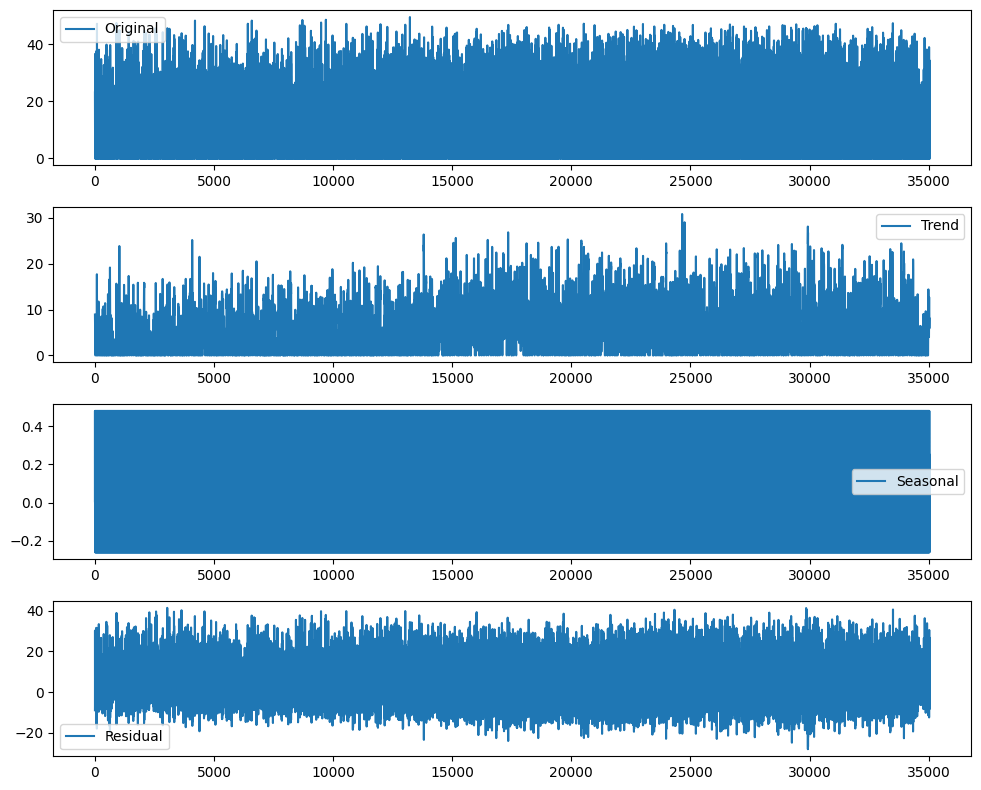

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# We have a pandas DataFrame with a 'PowerkW2' column

time_series_data = load_df['PowerkW2']

# Manually specify the seasonal period as 12 for monthly data
seasonal_period = 12

# Perform seasonal decomposition
result = seasonal_decompose(time_series_data, model='additive', period=seasonal_period)

# Plot the components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series_data, label='Original')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()
plt.tight_layout()
plt.show()



In [9]:
# Although the methods were prescribed for data which had a specific trend and seasonality within, we shall try and
# run it for this data which does not have an evident trend or seasonality since it is not identifiable atleast
# by visual inspection of the series plot

# We will start with naive forecasting. I will take the data till the month of August as my training set and then
# I will try and naive forecast it for the next month and see what we get.

In [ ]:
# January till 2976 , Feb till 5664 , March till 8640 , April till 11520 , May till 14496, June till 17376 ,
# July till 20352 and August till 23328 . September till 26208 , October till 29184 , November till 32064 ,
# and finally December till 35040.

import pandas as pd
import matplotlib.pyplot as plt

time_series_data = load_df['PowerkW2']

# Select the data for the month of August (time steps 20352 to 23328)
august_data = time_series_data[20448:23328]

# Calculate the naive forecast for September
naive_forecast_september = august_data

# Extract the actual values for September
september_data = time_series_data[23328:26208]

# Plot both the naive forecast and the actual values for September as dots
plt.figure(figsize=(40, 16))
plt.plot(september_data.index, september_data.values, label='Actual Values (September)', color='blue')
plt.plot(september_data.index, naive_forecast_september.values, label='Naive Forecast (August)', color='red')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Naive Forecast vs. Actual Values for September')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Baseline parameters: Mean squared error and Mean Absolute Error

print(tf.keras.metrics.mean_squared_error(september_data.values, naive_forecast_september.values).numpy())
print(tf.keras.metrics.mean_absolute_error(september_data.values, naive_forecast_september.values).numpy())

236.28728654959087
9.53503829090625


In [12]:
# Next method which we will use will be Moving Average Method to try and see what values of MSE & MAE we obtain.
def moving_average_forecast(series, window_size):
    """Generates a moving average forecast

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to compute the average for

    Returns:
      forecast (array of float) - the moving average forecast
    """

    # Initialize a list
    forecast = []
    
    # Compute the moving average based on the window size
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    
    # Convert to a numpy array
    forecast = np.array(forecast)

    return forecast

In [13]:
test_series = time_series_data[20448:23328]

# Generate the moving average forecast
moving_avg = moving_average_forecast(test_series, 30)

In [14]:
# Extract the actual values for September (01/09/22 7:28 onwards)
september_data_new = time_series_data[23358:26208]

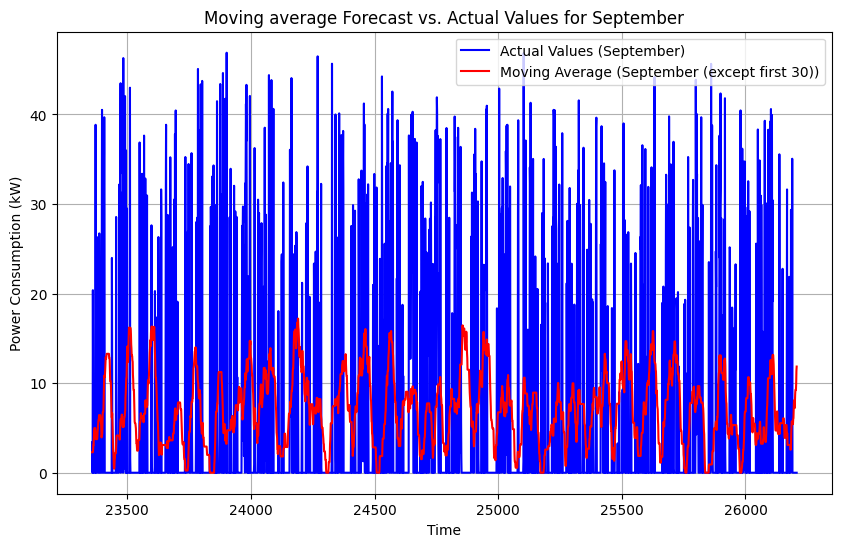

In [15]:
# Plot both the naive forecast and the actual values for September as dots
plt.figure(figsize=(10, 6))
plt.plot(september_data_new.index, september_data_new.values, label='Actual Values (September)', color='blue')
plt.plot(september_data_new.index, moving_avg, label='Moving Average (September (except first 30))', color='red')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Moving average Forecast vs. Actual Values for September')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Baseline parameters: Mean squared error and Mean Absolute Error

print(tf.keras.metrics.mean_squared_error(september_data_new.values, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(september_data_new.values, moving_avg).numpy())

143.75723879845125
9.259330545050526


In [17]:
# We see that moving average is better than the basic naive forecast in this case.

In [18]:
# Now we will use differencing and then calculate the moving avergae there to remove the trend and seasonality 
# factors and then we will add these back. The data in the course had a trand and seasonality which we really do 
# not have but still let us check out if it works better.

In [19]:
# Taking seasonality as 1 month.
# First we will do differencing and then get the moving average of the whole data and then to the moving average
# for the month of September we will add the values for th month of August.

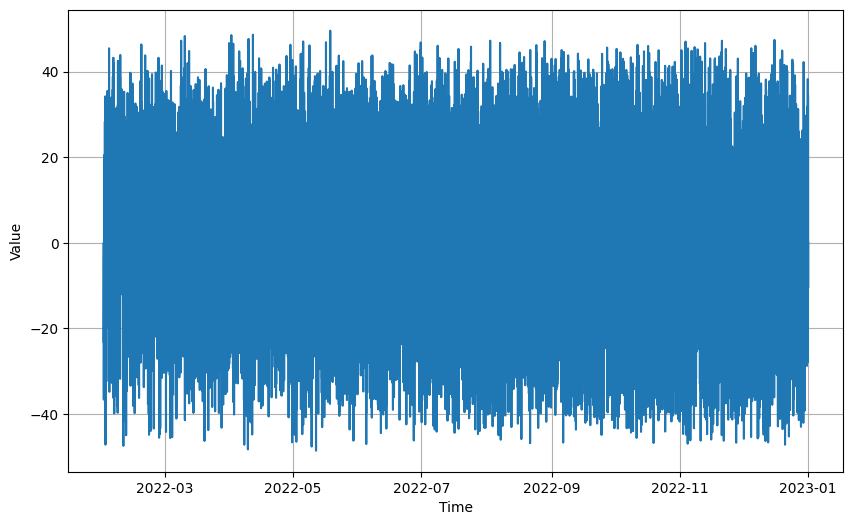

In [20]:
series1 = load_df['PowerkW2']

# Since the seasonality is taken to be 30 days.

# Subtract the previous 2880 values from each element
result = series1 - series1.shift(2880)

# Truncate the first 2880 time steps
result = result.dropna()


diff_time = time[2880:]

# Plot the results
plot_series(diff_time, result)

In [21]:
# Generate the moving average forecast for the complete forecast except the first 2880 values
moving_avg = moving_average_forecast(result, 30)

# Since each value is shifted by 2880 , the month of september now starts at 23328 - 2880 = 20448
series1_sept = result[20448:23328]
moving_avg_1 = moving_avg[20448:23328]

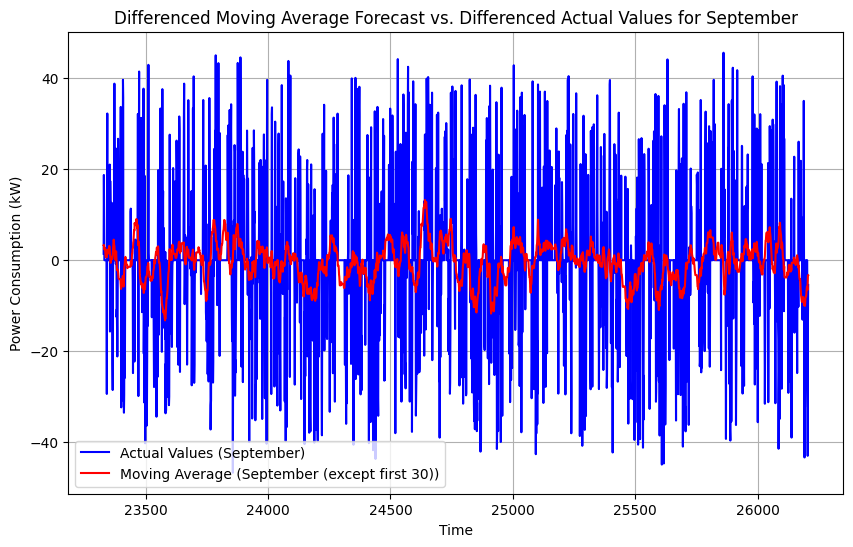

In [22]:
# Plot both the naive forecast and the actual values for September as dots
plt.figure(figsize=(10, 6))
plt.plot(series1_sept.index, series1_sept.values, label='Actual Values (September)', color='blue')
plt.plot(series1_sept.index, moving_avg_1, label='Moving Average (September (except first 30))', color='red')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Differenced Moving Average Forecast vs. Differenced Actual Values for September')
plt.legend()
plt.grid(True)
plt.show()

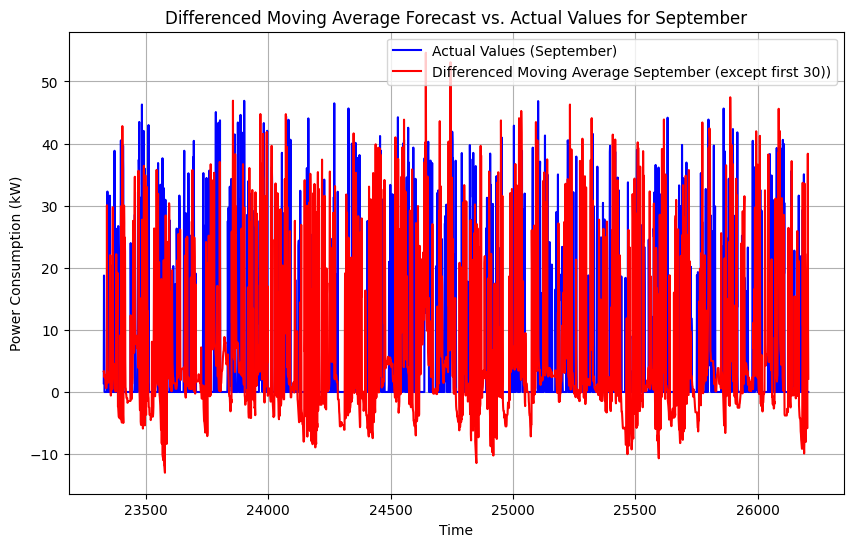

In [23]:
# Adding the value of Augusst data to the moving average of this

differenced_moving_average_plus =  time_series_data[20448:23328] + moving_avg_1 

# Extract the actual values for September
september_data_new = time_series_data[23328:26208]

# Plot both the naive forecast and the actual values for September as dots
plt.figure(figsize=(10, 6))
plt.plot(september_data_new.index, september_data_new.values, label='Actual Values (September)', color='blue')
plt.plot(september_data_new.index, differenced_moving_average_plus, label='Differenced Moving Average September (except first 30))', color='red')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Differenced Moving Average Forecast vs. Actual Values for September')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Baseline parameters: Mean squared error and Mean Absolute Error

print(tf.keras.metrics.mean_squared_error(september_data_new.values, differenced_moving_average_plus).numpy())
print(tf.keras.metrics.mean_absolute_error(september_data_new.values, differenced_moving_average_plus).numpy())

228.0781211335828
10.457252683624073


In [25]:
# The differenced moving average does not work that well probably becasue the original data barely had seasonality

In [26]:
# Doing Smoothening of the past data before adding it back ; using moving average over the past data
# Also making moving_avg_2 becasue the first 30 values willl be used for averaging here.

In [75]:
smoothened_past = moving_average_forecast(time_series_data[20448:23328] , 30)
moving_avg_2 = moving_avg[20478:23328]

series2_sept = smoothened_past + moving_avg_2
# Extract the actual values for September
september_data_2 = time_series_data[23358:26208]

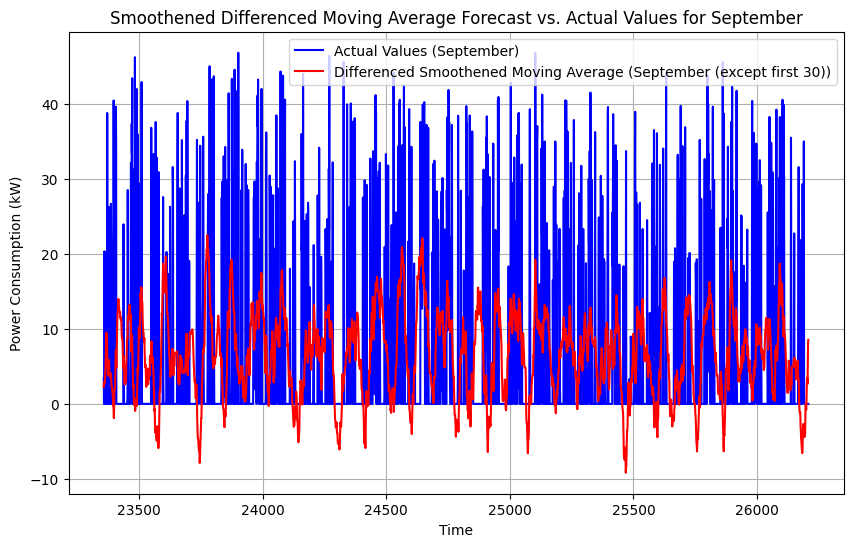

In [77]:
# Plot both the naive forecast and the actual values for September as dots
plt.figure(figsize=(10, 6))
plt.plot(september_data_2.index, september_data_2.values, label='Actual Values (September)', color='blue')
plt.plot(september_data_2.index, series2_sept, label='Differenced Smoothened Moving Average (September (except first 30))', color='red')
plt.xlabel('Time')
plt.ylabel('Power Consumption (kW)')
plt.title('Smoothened Differenced Moving Average Forecast vs. Actual Values for September')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# Baseline parameters: Mean squared error and Mean Absolute Error

print(tf.keras.metrics.mean_squared_error(september_data_2.values, series2_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(september_data_2.values, series2_sept).numpy())

147.15416522023077
9.284709709960936


In [30]:
# So these were all the methods without using ANN or DNN , next we will go for using DNNs
# First we will split our dataset into train and validation set, also we will generate batches and windows of data
# to be fed into the neural network

In [31]:
def plot_series_2(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [40]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [32]:
# Define the split time
split_time_number = 23328

# Get the train set 
time_train = time[:split_time_number]
x_train = series[:split_time_number]

# Get the validation set
time_valid = time[split_time_number:]
x_valid = series[split_time_number:]

In [33]:
import tensorflow as tf

# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [34]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [35]:
# Print the first 5 results
count = 0
for x, y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()
    count += 1
    if count >= 5:  # Limit the output to the first 5 results
        break


x =  [[ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         5.668236  25.49221
   8.211225   2.284117   0.         0.         0.         0.
   0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.       ]
 [38.37662   39.35433   39.76236    5.562057  19.01353   17.20614
   0.         0.         0.         0.         0.         0.
  13.25486   12.17662    0.8267647  0.         0.         0.
  17.87353   31.00942  ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.    

In [36]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.01795185],
       [-0.27352327],
       [-0.40497223],
       [ 0.11822104],
       [ 0.32527387],
       [-0.2715947 ],
       [ 0.01039594],
       [ 0.40775108],
       [-0.24128208],
       [ 0.45159608],
       [ 0.08951032],
       [-0.02787739],
       [ 0.24386835],
       [ 0.4123004 ],
       [-0.03255522],
       [ 0.38699144],
       [ 0.02064747],
       [ 0.18619573],
       [ 0.43804818],
       [-0.08866796]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [38]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
729/729 [==============================] - 1s 1ms/step - loss: 134.6084
Epoch 2/100
729/729 [==============================] - 1s 1ms/step - loss: 90.4627
Epoch 3/100
729/729 [==============================] - 1s 1ms/step - loss: 84.0260
Epoch 4/100
729/729 [==============================] - 1s 1ms/step - loss: 82.4614
Epoch 5/100
729/729 [==============================] - 1s 1ms/step - loss: 82.0235
Epoch 6/100
729/729 [==============================] - 1s 1ms/step - loss: 81.8822
Epoch 7/100
729/729 [==============================] - 1s 1ms/step - loss: 81.8113
Epoch 8/100
729/729 [==============================] - 1s 1ms/step - loss: 81.7893
Epoch 9/100
729/729 [==============================] - 1s 1ms/step - loss: 81.7578
Epoch 10/100
729/729 [==============================] - 1s 1ms/step - loss: 81.7683
Epoch 11/100
729/729 [==============================] - 1s 1ms/step - loss: 81.7317
Epoch 12/100
729/729 [==============================] - 1s 1ms/step - loss: 81.7097


In [37]:
# So basically this code gives us all of the predictions except the first 20 points so now we can slice and find
# the septemeber points and then compare.

series = load_df['PowerkW2']

# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
    input_window = series[time:time + window_size].values.reshape(1, -1)
    forecast.append(model.predict(input_window))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


In [41]:
split_time = 23328

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast_ANN = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results_ANN = forecast_ANN.squeeze()

366/366 [==============================] - 0s 1ms/step


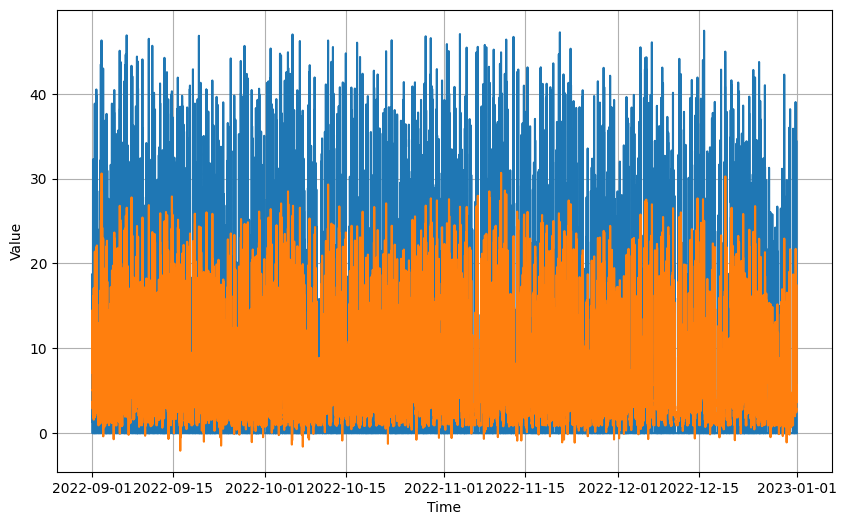

In [42]:
plot_series_2(time_valid, (x_valid, results_ANN))

In [43]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results_ANN).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_ANN).numpy())

104.16404
6.771857


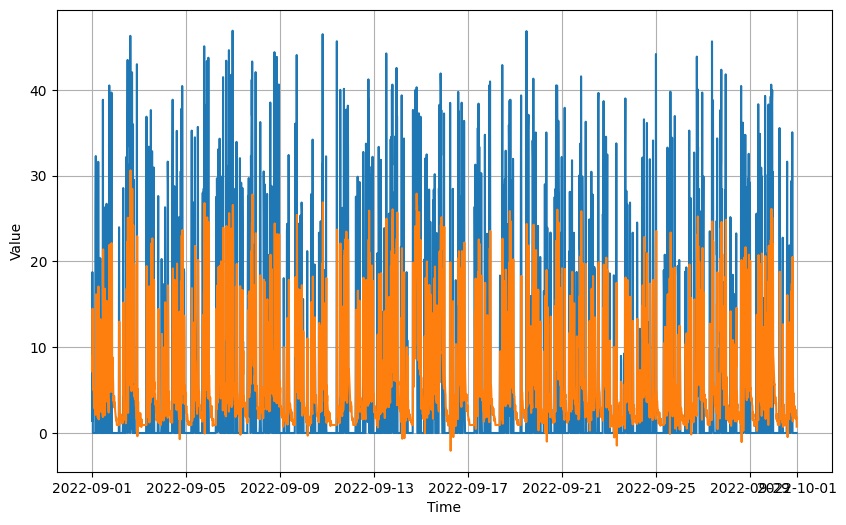

In [44]:
time_valid_sept = time_valid[:2880]

forecast_validation_sept = forecast_ANN[:2880]

results_ANN_sept = np.array(forecast_validation_sept).squeeze()

x_valid_sept = x_valid[:2880]

plot_series_2(time_valid_sept, (x_valid_sept, results_ANN_sept))

In [56]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid_sept, results_ANN_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid_sept, results_ANN_sept).numpy())

110.108315
7.050768


In [129]:
# We are able to show that the prediction for the month of september are also much better than a single naive 
# forecast or any of the stastical methods we had used before this. Next we will go for DNNs

In [61]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331 (1.29 KB)
Trainable params: 331 (1.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [63]:
# Train the model
model_baseline.fit(dataset,epochs=200)

Epoch 1/200
729/729 [==============================] - 1s 1ms/step - loss: 103.5594
Epoch 2/200
729/729 [==============================] - 1s 1ms/step - loss: 95.7719
Epoch 3/200
729/729 [==============================] - 1s 1ms/step - loss: 92.4379
Epoch 4/200
729/729 [==============================] - 1s 1ms/step - loss: 90.0214
Epoch 5/200
729/729 [==============================] - 1s 2ms/step - loss: 88.2915
Epoch 6/200
729/729 [==============================] - 1s 1ms/step - loss: 87.0032
Epoch 7/200
729/729 [==============================] - 1s 1ms/step - loss: 86.0903
Epoch 8/200
729/729 [==============================] - 1s 1ms/step - loss: 85.4315
Epoch 9/200
729/729 [==============================] - 1s 1ms/step - loss: 84.9540
Epoch 10/200
729/729 [==============================] - 1s 1ms/step - loss: 84.5040
Epoch 11/200
729/729 [==============================] - 1s 1ms/step - loss: 84.1891
Epoch 12/200
729/729 [==============================] - 1s 1ms/step - loss: 83.9375


729/729 [==============================] - 1s 1ms/step - loss: 77.0329
Epoch 195/200
729/729 [==============================] - 1s 1ms/step - loss: 77.0031
Epoch 196/200
729/729 [==============================] - 1s 1ms/step - loss: 76.9672
Epoch 197/200
729/729 [==============================] - 1s 1ms/step - loss: 76.9252
Epoch 198/200
729/729 [==============================] - 1s 1ms/step - loss: 76.9163
Epoch 199/200
729/729 [==============================] - 1s 1ms/step - loss: 76.8665
Epoch 200/200
729/729 [==============================] - 1s 1ms/step - loss: 76.8186


In [64]:
split_time = 23328

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast_DNN = model_forecast(model_baseline, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results_DNN = forecast_DNN.squeeze()


366/366 [==============================] - 0s 1ms/step


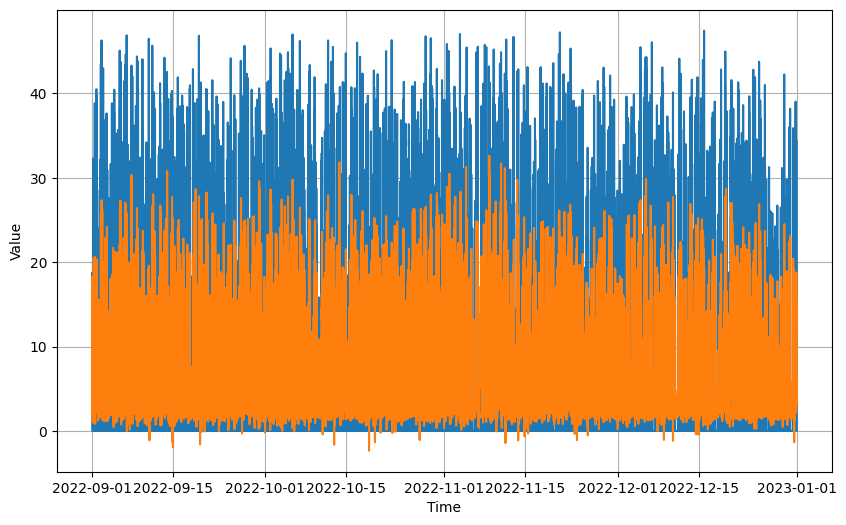

In [65]:
plot_series_2(time_valid, (x_valid, results_DNN))

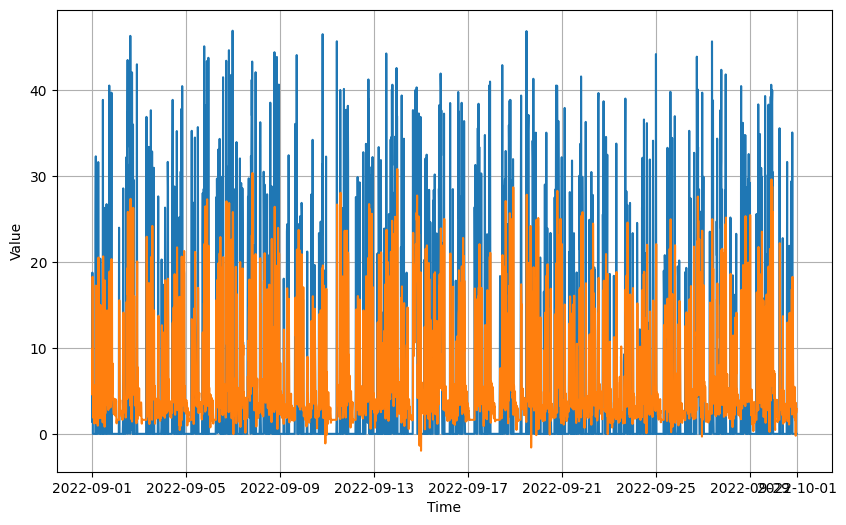

In [66]:
results_DNN_sept = results_DNN[:2880]

x_valid_sept = x_valid[:2880]

plot_series_2(time_valid_sept, (x_valid_sept, results_DNN_sept))


In [67]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results_DNN).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_DNN).numpy())

101.192375
6.910655


In [68]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid_sept, results_DNN_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid_sept, results_DNN_sept).numpy())

106.16927
7.1458516


In [62]:
# Surprisingly the ANN works better than DNN.

In [143]:
# Next is trying to optimize the learning rate using a learning rate scheduler

In [144]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [145]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [146]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

In [147]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
729/729 [==============================] - 1s 1ms/step - loss: 163.4523 - lr: 1.0000e-08
Epoch 2/100
729/729 [==============================] - 1s 2ms/step - loss: 160.3158 - lr: 1.1220e-08
Epoch 3/100
729/729 [==============================] - 1s 1ms/step - loss: 157.1236 - lr: 1.2589e-08
Epoch 4/100
729/729 [==============================] - 1s 1ms/step - loss: 153.8747 - lr: 1.4125e-08
Epoch 5/100
729/729 [==============================] - 1s 1ms/step - loss: 150.5941 - lr: 1.5849e-08
Epoch 6/100
729/729 [==============================] - 1s 1ms/step - loss: 147.2797 - lr: 1.7783e-08
Epoch 7/100
729/729 [==============================] - 1s 1ms/step - loss: 143.9332 - lr: 1.9953e-08
Epoch 8/100
729/729 [==============================] - 1s 1ms/step - loss: 140.5552 - lr: 2.2387e-08
Epoch 9/100
729/729 [==============================] - 1s 1ms/step - loss: 137.1441 - lr: 2.5119e-08
Epoch 10/100
729/729 [==============================] - 1s 1ms/step - loss: 133.6999 - lr: 

Epoch 82/100
729/729 [==============================] - 2s 2ms/step - loss: 80.4188 - lr: 1.1220e-04
Epoch 83/100
729/729 [==============================] - 1s 2ms/step - loss: 79.7815 - lr: 1.2589e-04
Epoch 84/100
729/729 [==============================] - 1s 2ms/step - loss: 79.8804 - lr: 1.4125e-04
Epoch 85/100
729/729 [==============================] - 2s 2ms/step - loss: 82.4405 - lr: 1.5849e-04
Epoch 86/100
729/729 [==============================] - 1s 2ms/step - loss: 80.9724 - lr: 1.7783e-04
Epoch 87/100
729/729 [==============================] - 1s 2ms/step - loss: 80.9536 - lr: 1.9953e-04
Epoch 88/100
729/729 [==============================] - 1s 2ms/step - loss: 84.0179 - lr: 2.2387e-04
Epoch 89/100
729/729 [==============================] - 1s 1ms/step - loss: 81.1669 - lr: 2.5119e-04
Epoch 90/100
729/729 [==============================] - 1s 1ms/step - loss: 82.8355 - lr: 2.8184e-04
Epoch 91/100
729/729 [==============================] - 1s 2ms/step - loss: 82.9626 - lr: 3

(1e-08, 0.001, 0.0, 300.0)

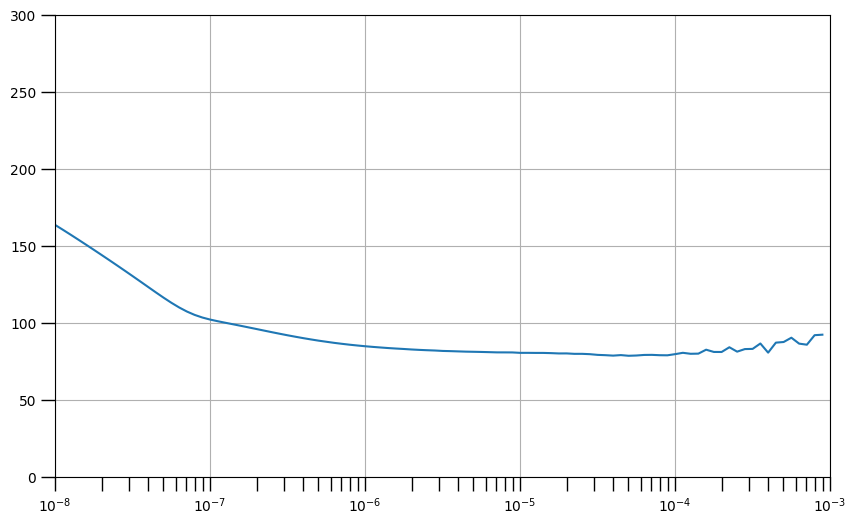

In [148]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [149]:
# Although we can now run it with some better value like e-5 and then see it converge faster and better , I don't 
# feel it will be much valuable in our case and hence I will be moving on to the next thing RNNs

In [150]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_17 (Dense)            (None, 1)                 41        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4961 (19.38 KB)
Trainable params: 4961 (19.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [151]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
729/729 [==============================] - 3s 3ms/step - loss: 53.8925 - lr: 1.0000e-08
Epoch 2/100
729/729 [==============================] - 2s 3ms/step - loss: 45.5529 - lr: 1.1220e-08
Epoch 3/100
729/729 [==============================] - 2s 3ms/step - loss: 38.3025 - lr: 1.2589e-08
Epoch 4/100
729/729 [==============================] - 2s 3ms/step - loss: 31.6915 - lr: 1.4125e-08
Epoch 5/100
729/729 [==============================] - 2s 3ms/step - loss: 25.9067 - lr: 1.5849e-08
Epoch 6/100
729/729 [==============================] - 2s 3ms/step - loss: 21.8560 - lr: 1.7783e-08
Epoch 7/100
729/729 [==============================] - 2s 3ms/step - loss: 19.7992 - lr: 1.9953e-08
Epoch 8/100
729/729 [==============================] - 2s 3ms/step - loss: 18.4185 - lr: 2.2387e-08
Epoch 9/100
729/729 [==============================] - 2s 3ms/step - loss: 17.2725 - lr: 2.5119e-08
Epoch 10/100
729/729 [==============================] - 2s 3ms/step - loss: 16.2534 - lr: 2.8184e-08

Epoch 83/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1946 - lr: 1.2589e-04
Epoch 84/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1607 - lr: 1.4125e-04
Epoch 85/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1029 - lr: 1.5849e-04
Epoch 86/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1539 - lr: 1.7783e-04
Epoch 87/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1354 - lr: 1.9953e-04
Epoch 88/100
729/729 [==============================] - 2s 3ms/step - loss: 4.2618 - lr: 2.2387e-04
Epoch 89/100
729/729 [==============================] - 2s 3ms/step - loss: 4.1163 - lr: 2.5119e-04
Epoch 90/100
729/729 [==============================] - 2s 3ms/step - loss: 4.2729 - lr: 2.8184e-04
Epoch 91/100
729/729 [==============================] - 2s 3ms/step - loss: 4.3346 - lr: 3.1623e-04
Epoch 92/100
729/729 [==============================] - 2s 3ms/step - loss: 4.4590 - lr: 3.5481e-04


(1e-08, 0.001, 0.0, 50.0)

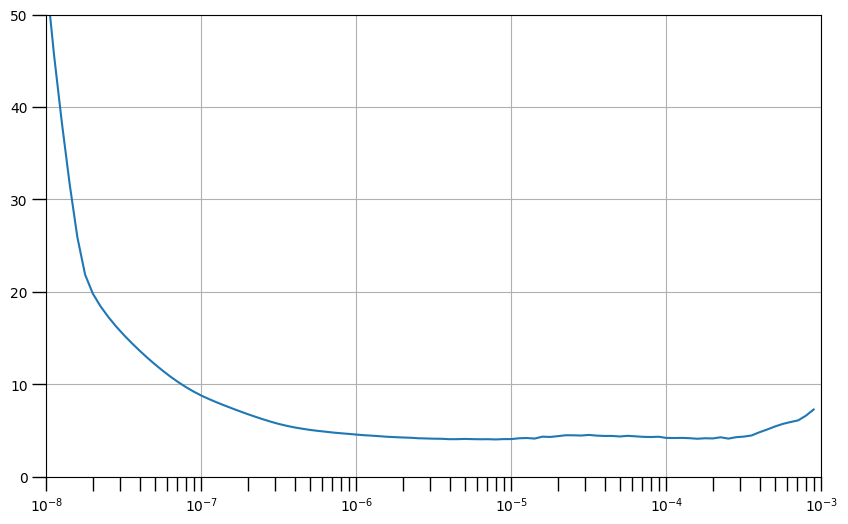

In [168]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [46]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
729/729 [==============================] - 4s 3ms/step - loss: 7.1045 - mae: 7.5653
Epoch 2/100
729/729 [==============================] - 3s 3ms/step - loss: 4.5317 - mae: 4.9713
Epoch 3/100
729/729 [==============================] - 3s 3ms/step - loss: 4.3523 - mae: 4.7824
Epoch 4/100
729/729 [==============================] - 3s 3ms/step - loss: 4.1888 - mae: 4.6064
Epoch 5/100
729/729 [==============================] - 3s 3ms/step - loss: 4.0900 - mae: 4.4970
Epoch 6/100
729/729 [==============================] - 3s 3ms/step - loss: 4.1284 - mae: 4.5417
Epoch 7/100
729/729 [==============================] - 3s 3ms/step - loss: 4.0328 - mae: 4.4351
Epoch 8/100
729/729 [==============================] - 3s 3ms/step - loss: 4.0866 - mae: 4.5035
Epoch 9/100
729/729 [==============================] - 3s 3ms/step - loss: 4.0119 - mae: 4.4090
Epoch 10/100
729/729 [==============================] - 3s 3ms/step - loss: 4.0562 - mae: 4.4604
Epoch 11/100
729/729 [=================

In [170]:
# Initialize a list
forecast_2 = []

split_time = 23328 

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    input_window = series[time:time + window_size].values.reshape(1, -1)
    forecast_2.append(model.predict(input_window))
    
    
# Vertically stack the arrays in the forecast list
forecast_combined_3 = np.vstack(forecast_2)
forecast_combined_3.shape

results_2 = np.array(forecast_combined_3).squeeze()


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


In [51]:
# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast_RNN = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results_RNN = forecast_RNN.squeeze()

366/366 [==============================] - 0s 1ms/step


In [55]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results_RNN).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_RNN).numpy())

96.22285
5.1305556


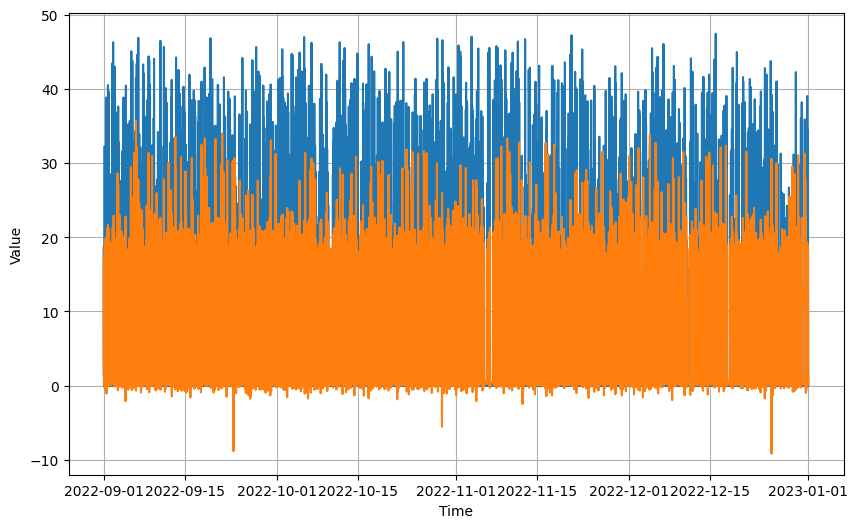

In [53]:
plot_series_2(time_valid, (x_valid, results_RNN))

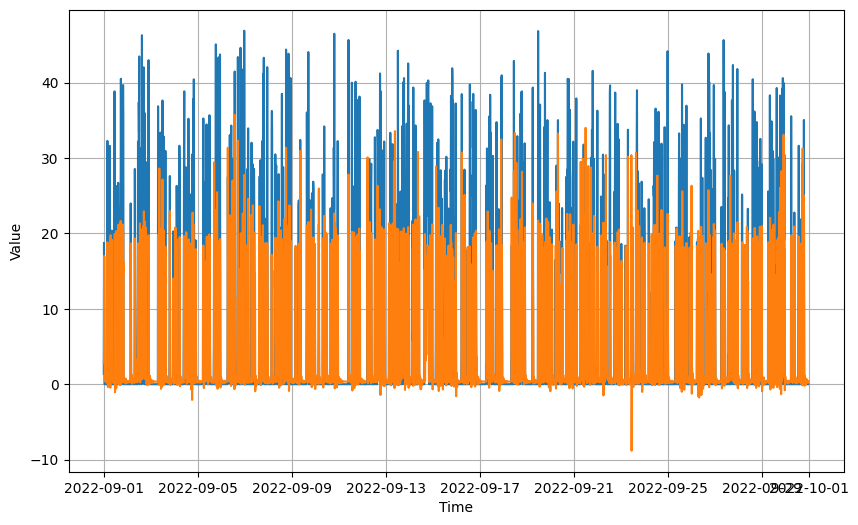

In [54]:
# Just for the month of September 

results_RNN_sept = results_RNN[:2880]

time_valid_sept = time_valid[:2880]

plot_series_2(time_valid_sept, (x_valid_sept, results_RNN_sept))


In [56]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid_sept, results_RNN_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid_sept, results_RNN_sept).numpy())

96.881714
5.1661267


In [67]:
# This is the best we have got till now and by a margin.

In [58]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 20, 64)            8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 3360

In [63]:
# # Set the learning rate scheduler
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

# # Initialize the optimizer
# optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# # Set the training parameters
# model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# # Train the model
# history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

(1e-08, 0.001, 0.0, 30.0)

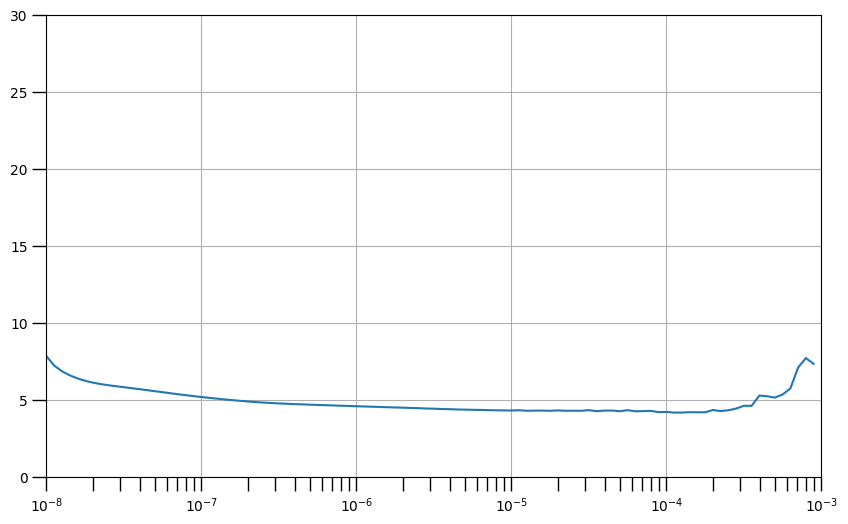

In [176]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [71]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 10**-5

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

In [64]:
split_time = 23328

# Reduce the original series
forecast_series_LSTM = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast_LSTM = model_forecast(model, forecast_series_LSTM, window_size, batch_size)

# Drop single dimensional axis
results_LSTM = forecast_LSTM.squeeze()



366/366 [==============================] - 2s 2ms/step


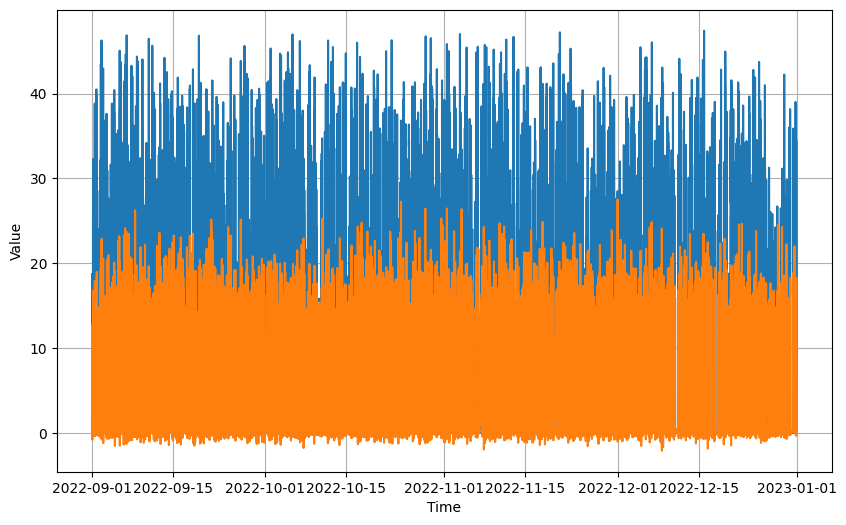

In [65]:
# Plot the results
plot_series_2(time_valid, (x_valid, results_LSTM))

In [66]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results_LSTM).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_LSTM).numpy())

101.5853
5.196068


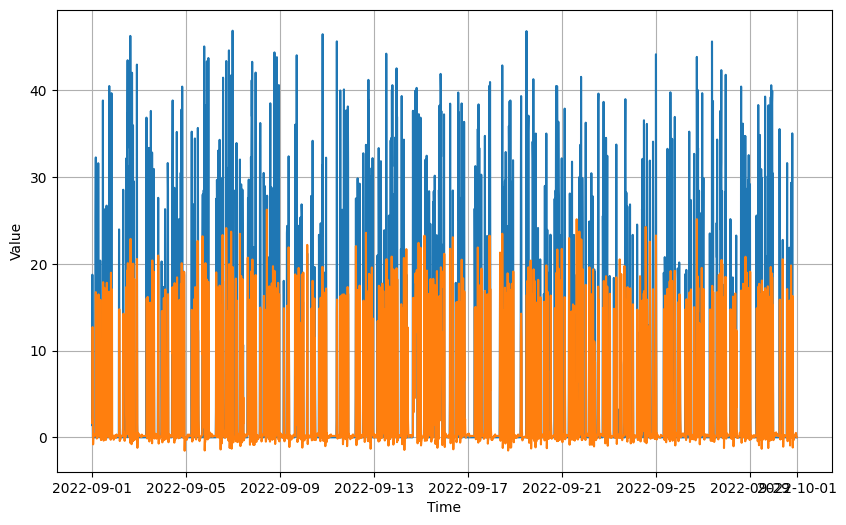

In [67]:
# Just for the month of September: 

results_LSTM_sept = results_LSTM[:2880]

time_valid_sept = time_valid[:2880]

plot_series_2(time_valid_sept, (x_valid_sept, results_LSTM_sept))


In [68]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid_sept, results_LSTM_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid_sept, results_LSTM_sept).numpy())

102.90028
5.2680297


In [93]:
# The final method is CNN + LSTMs

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66369 (259.25 KB)
Trainable params: 66369 (259.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# Get initial weights
init_weights = model.get_weights()

In [95]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
729/729 [==============================] - 11s 13ms/step - loss: 13.7947 - lr: 1.0000e-08
Epoch 2/100
729/729 [==============================] - 10s 13ms/step - loss: 7.6229 - lr: 1.1220e-08
Epoch 3/100
729/729 [==============================] - 10s 13ms/step - loss: 6.8149 - lr: 1.2589e-08
Epoch 4/100
729/729 [==============================] - 10s 13ms/step - loss: 6.5868 - lr: 1.4125e-08
Epoch 5/100
729/729 [==============================] - 10s 13ms/step - loss: 6.4479 - lr: 1.5849e-08
Epoch 6/100
729/729 [==============================] - 10s 13ms/step - loss: 6.3246 - lr: 1.7783e-08
Epoch 7/100
729/729 [==============================] - 10s 13ms/step - loss: 6.2065 - lr: 1.9953e-08
Epoch 8/100
729/729 [==============================] - 10s 13ms/step - loss: 6.0937 - lr: 2.2387e-08
Epoch 9/100
729/729 [==============================] - 10s 13ms/step - loss: 5.9792 - lr: 2.5119e-08
Epoch 10/100
729/729 [==============================] - 10s 14ms/step - loss: 5.8715 - lr:

(1e-08, 0.001, 0.0, 50.0)

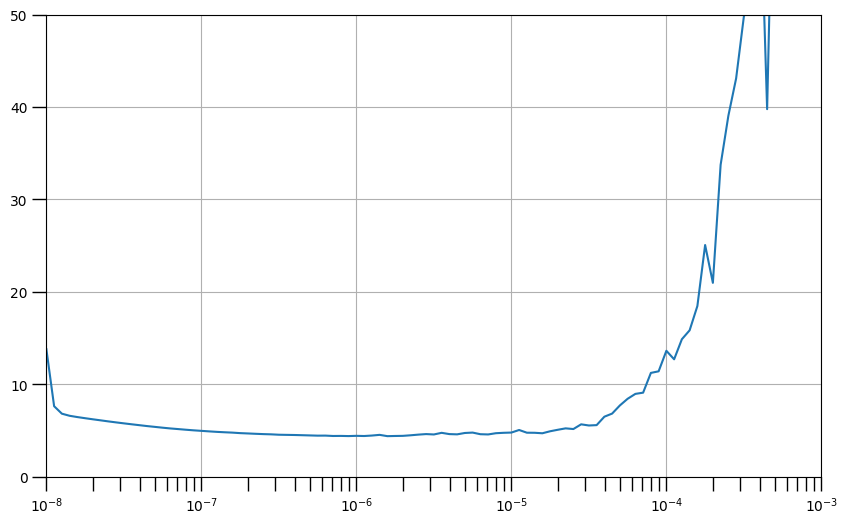

In [96]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

In [97]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [98]:
# Set the learning rate
learning_rate = 1e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [99]:
# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
729/729 [==============================] - 11s 13ms/step - loss: 5.8988 - mae: 6.3462
Epoch 2/100
729/729 [==============================] - 10s 13ms/step - loss: 4.9200 - mae: 5.3518
Epoch 3/100
729/729 [==============================] - 10s 13ms/step - loss: 4.6968 - mae: 5.1168
Epoch 4/100
729/729 [==============================] - 10s 13ms/step - loss: 4.6633 - mae: 5.0853
Epoch 5/100
729/729 [==============================] - 10s 13ms/step - loss: 4.5399 - mae: 4.9499
Epoch 6/100
729/729 [==============================] - 10s 13ms/step - loss: 4.4833 - mae: 4.8913
Epoch 7/100
729/729 [==============================] - 10s 13ms/step - loss: 4.4754 - mae: 4.8881
Epoch 8/100
729/729 [==============================] - 10s 13ms/step - loss: 4.4219 - mae: 4.8201
Epoch 9/100
729/729 [==============================] - 10s 13ms/step - loss: 4.4007 - mae: 4.8042
Epoch 10/100
729/729 [==============================] - 10s 13ms/step - loss: 4.3802 - mae: 4.7826
Epoch 11/100
729/72

In [100]:
def plot_series_3(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


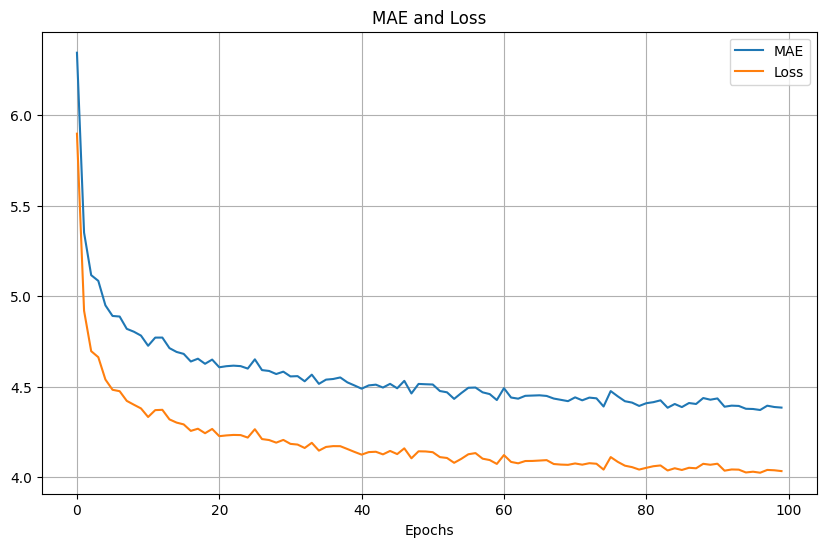

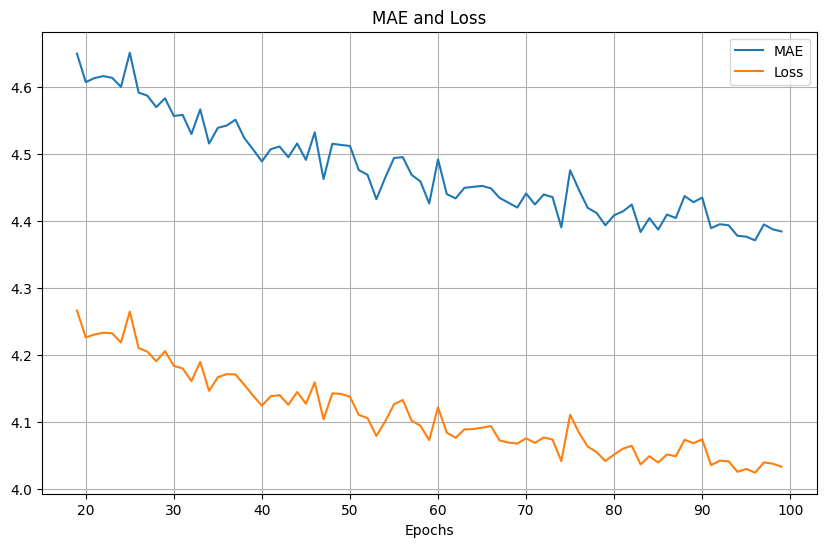

In [101]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series_3(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series_3(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )

366/366 [==============================] - 2s 4ms/step


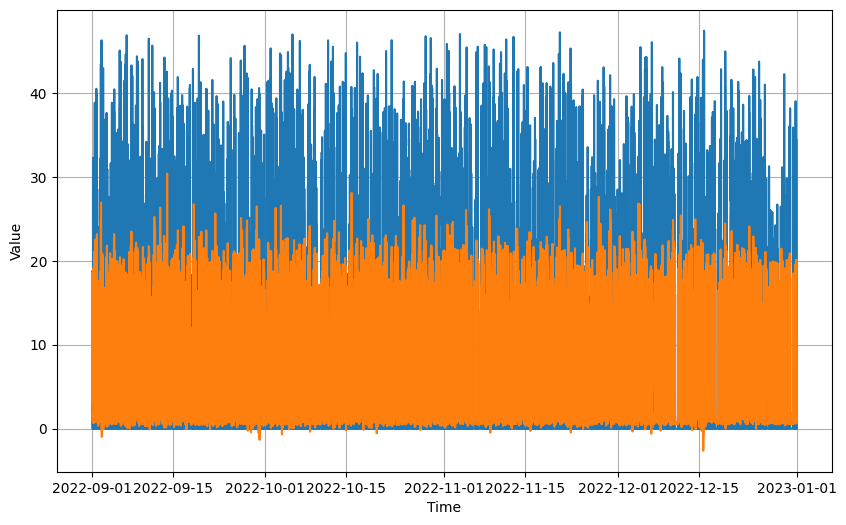

In [102]:
# Reduce the original series
forecast_series_CNN = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast_CNN = model_forecast(model, forecast_series_CNN, window_size, batch_size)

# Drop single dimensional axes
results_CNN = forecast_CNN.squeeze()

# Plot the results
plot_series_2(time_valid, (x_valid, results_CNN))

In [103]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results_CNN).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_CNN).numpy())

99.23518
5.6699986


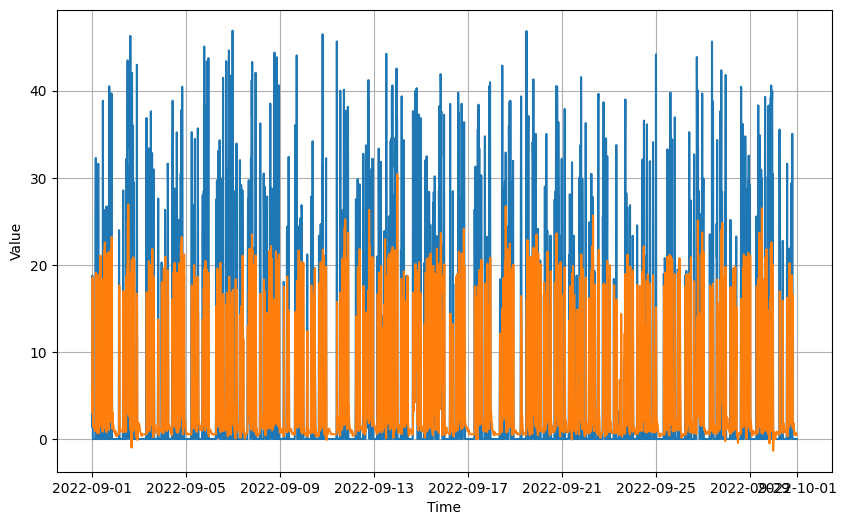

In [104]:
results_CNN_sept = results_CNN[:2880]

time_valid_sept = time_valid[:2880]

plot_series_2(time_valid_sept, (x_valid_sept, results_CNN_sept))

In [105]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid_sept, results_CNN_sept).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid_sept, results_CNN_sept).numpy())

101.842636
5.778783


In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirection  (None, None, 64)          8704      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33601 (131.25 KB)
Trainable params: 33601 